In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'IAC'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,740,-209,531,34,1003,241,0,1471,1716,...,68,0,0,601,1080,2515,43,-10,88.558,2014-05-05
1,2014-06-30,756,-211,546,-18,987,223,0,1477,1721,...,59,0,0,588,1080,2495,106,-17,88.558,2014-08-04
2,2014-09-30,782,-226,556,150,932,235,0,1455,1799,...,75,0,0,654,1080,2263,146,-12,88.558,2014-11-04
3,2014-12-31,831,-214,617,68,990,236,0,1536,1755,...,81,0,0,674,1080,2265,129,-18,88.558,2015-03-01
4,2015-03-31,773,-192,581,22,672,232,0,1294,1721,...,83,0,0,625,1080,2205,-4,-13,88.267,2015-05-05


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-05-05,86.464,1084,-342,743,415,1399,538,0,...,1116,10754,115,0,30,999,2013,4487,25,-22
37,2023-06-30,2023-08-04,86.464,1112,-353,759,-92,1327,522,0,...,1062,10549,128,0,30,1035,2006,4432,103,-86
38,2023-09-30,2023-11-04,86.464,1111,-342,769,-392,1252,519,0,...,1001,10018,144,0,30,1024,2001,4277,14,-19
39,2023-12-31,2024-02-29,86.464,1058,-305,753,327,1297,537,0,...,875,10371,106,0,30,950,1993,4293,47,-15
40,2024-03-31,2024-05-06,85.860,929,-272,657,45,1506,464,0,...,830,10359,84,0,34,855,1982,3543,64,-16


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-05,86.464,1084,-342,743,415,1399,538,0,...,10754,115,0,30,999,2013,4487,25,-22,1
37,2023-06-30,2023-08-04,86.464,1112,-353,759,-92,1327,522,0,...,10549,128,0,30,1035,2006,4432,103,-86,1
38,2023-09-30,2023-11-04,86.464,1111,-342,769,-392,1252,519,0,...,10018,144,0,30,1024,2001,4277,14,-19,1
39,2023-12-31,2024-02-29,86.464,1058,-305,753,327,1297,537,0,...,10371,106,0,30,950,1993,4293,47,-15,1
40,2024-03-31,2024-05-06,85.860,929,-272,657,45,1506,464,0,...,10359,84,0,34,855,1982,3543,64,-16,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-05,86.464,1084.0,-342.0,743.0,415.0,1399.0,538.0,0.0,...,10754.0,115.0,0.0,30.0,999.0,2013.0,4487.0,25.0,-22.0,1
37,2023-06-30,2023-08-04,86.464,1112.0,-353.0,759.0,-92.0,1327.0,522.0,0.0,...,10549.0,128.0,0.0,30.0,1035.0,2006.0,4432.0,103.0,-86.0,1
38,2023-09-30,2023-11-04,86.464,1111.0,-342.0,769.0,-392.0,1252.0,519.0,0.0,...,10018.0,144.0,0.0,30.0,1024.0,2001.0,4277.0,14.0,-19.0,1
39,2023-12-31,2024-02-29,86.464,1058.0,-305.0,753.0,327.0,1297.0,537.0,0.0,...,10371.0,106.0,0.0,30.0,950.0,1993.0,4293.0,47.0,-15.0,1
40,2024-03-31,2024-05-06,85.860,929.0,-272.0,657.0,45.0,1506.0,464.0,0.0,...,10359.0,84.0,0.0,34.0,855.0,1982.0,3543.0,64.0,-16.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-05,13.408386,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.404593,0.595407,0.0,0.0,0.0,0.0,0.717568,0.045946,0.0,0.0
1,2014-05-12,13.223124,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.404593,0.595407,0.0,0.0,0.0,0.0,0.717568,0.045946,0.0,0.0
2,2014-05-19,13.198134,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.404593,0.595407,0.0,0.0,0.0,0.0,0.717568,0.045946,0.0,0.0
3,2014-05-26,13.990530,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.404593,0.595407,0.0,0.0,0.0,0.0,0.717568,0.045946,0.0,0.0
4,2014-06-02,14.195496,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.404593,0.595407,0.0,0.0,0.0,0.0,0.717568,0.045946,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-05,13.408386,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.0,0.717568,0.045946,0.0,0.0,inf,0.694804,0.401155,0.911966,inf
1,2014-05-12,13.223124,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.0,0.717568,0.045946,0.0,0.0,inf,0.685204,0.395613,0.906423,inf
2,2014-05-19,13.198134,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.0,0.717568,0.045946,0.0,0.0,inf,0.683909,0.394865,0.905676,inf
3,2014-05-26,13.990530,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.0,0.717568,0.045946,0.0,0.0,inf,0.724970,0.418572,0.929383,inf
4,2014-06-02,14.195496,2014-03-31,740.0,0.0,19.298087,88.558,0.0,0.0,1003.0,...,0.0,0.717568,0.045946,0.0,0.0,inf,0.735591,0.424704,0.935515,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

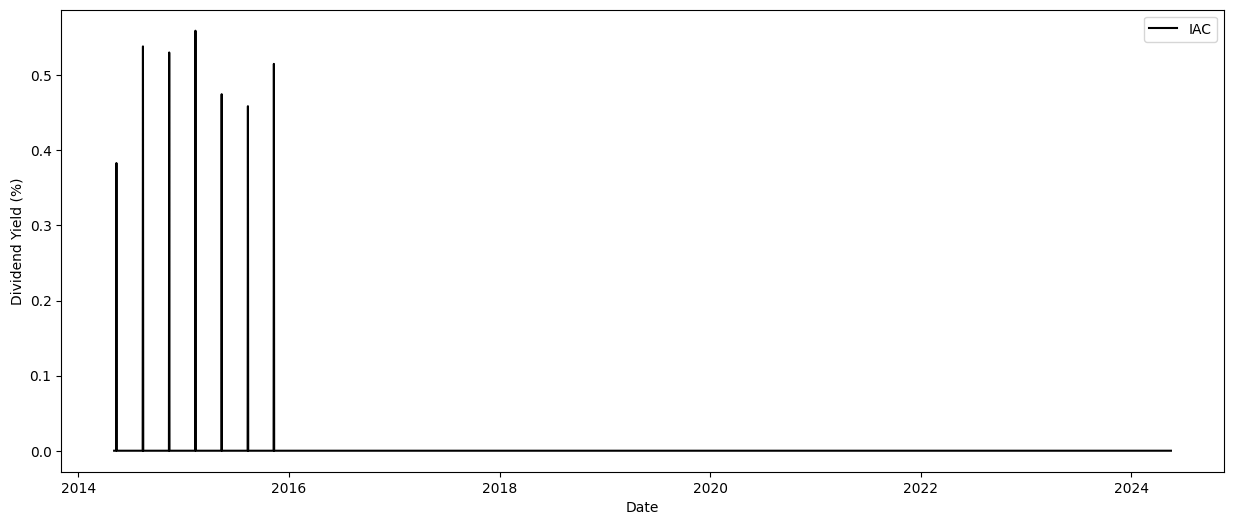

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


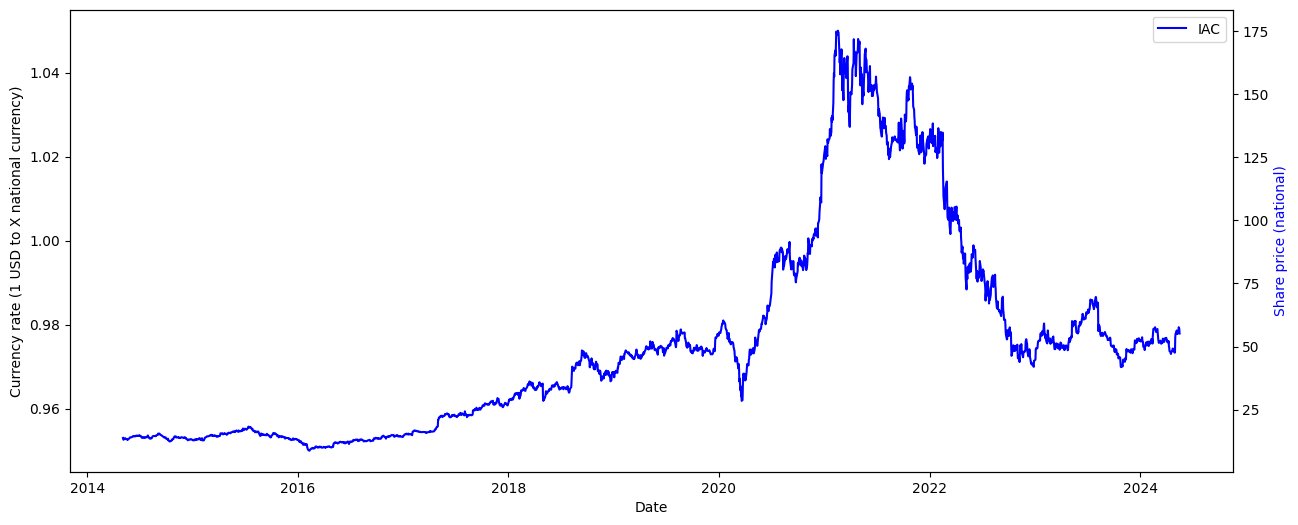

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

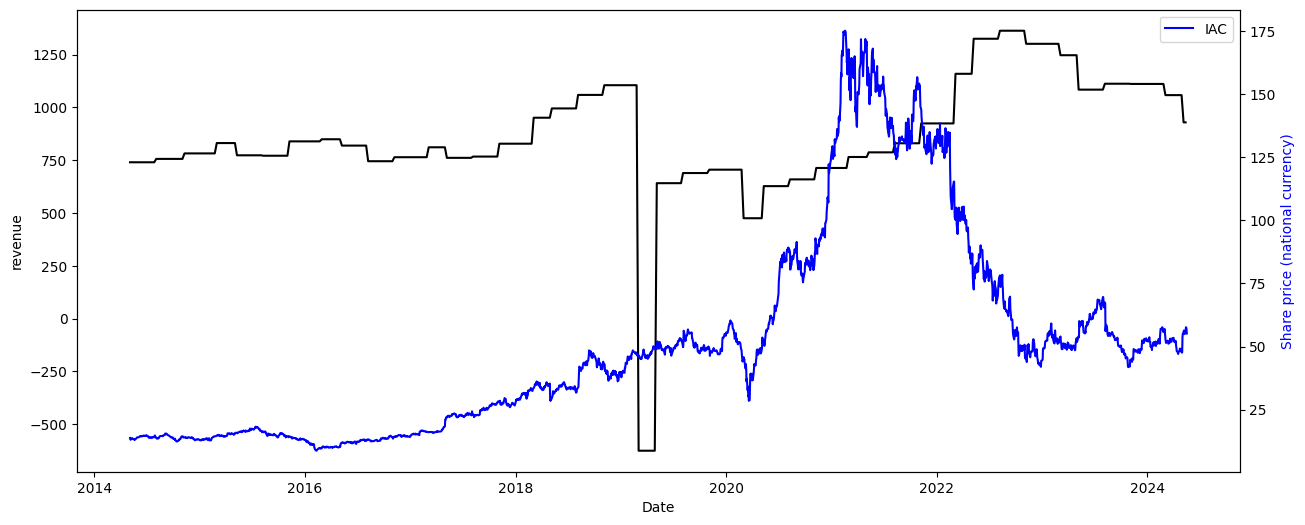

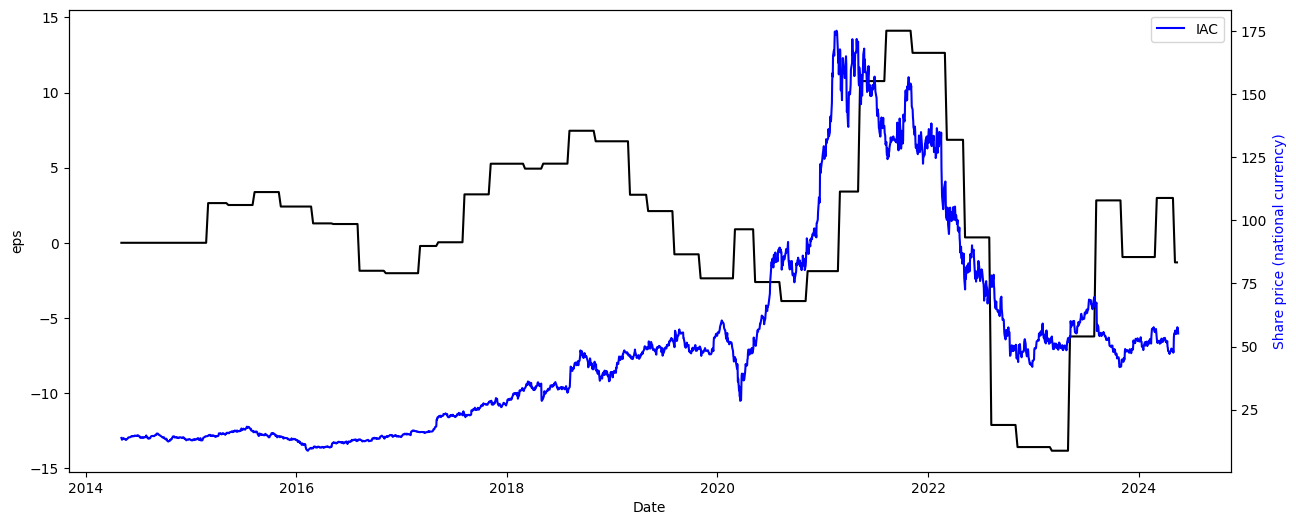

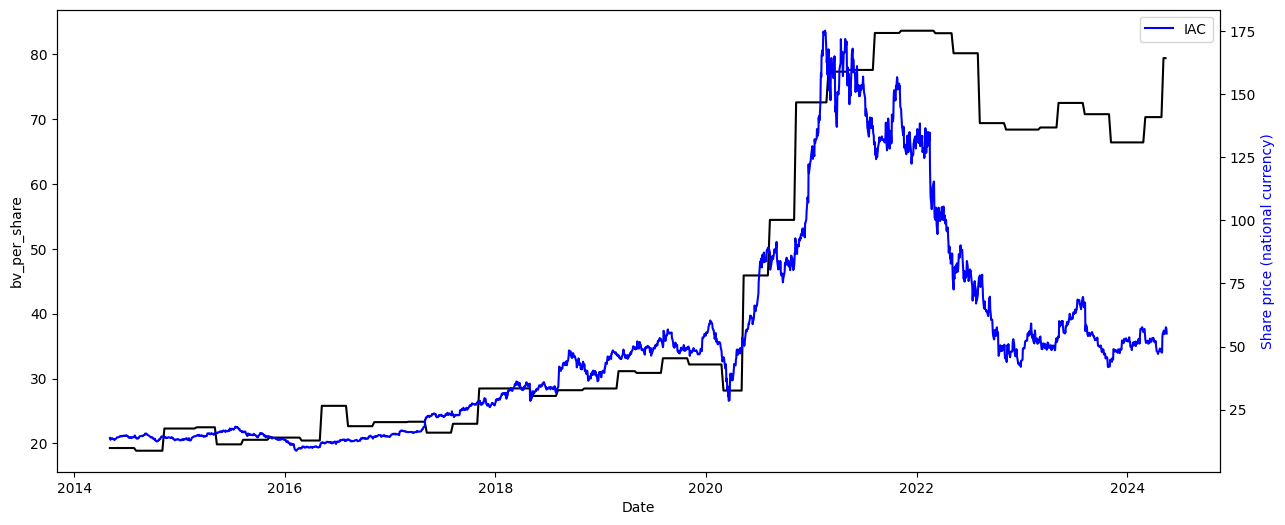

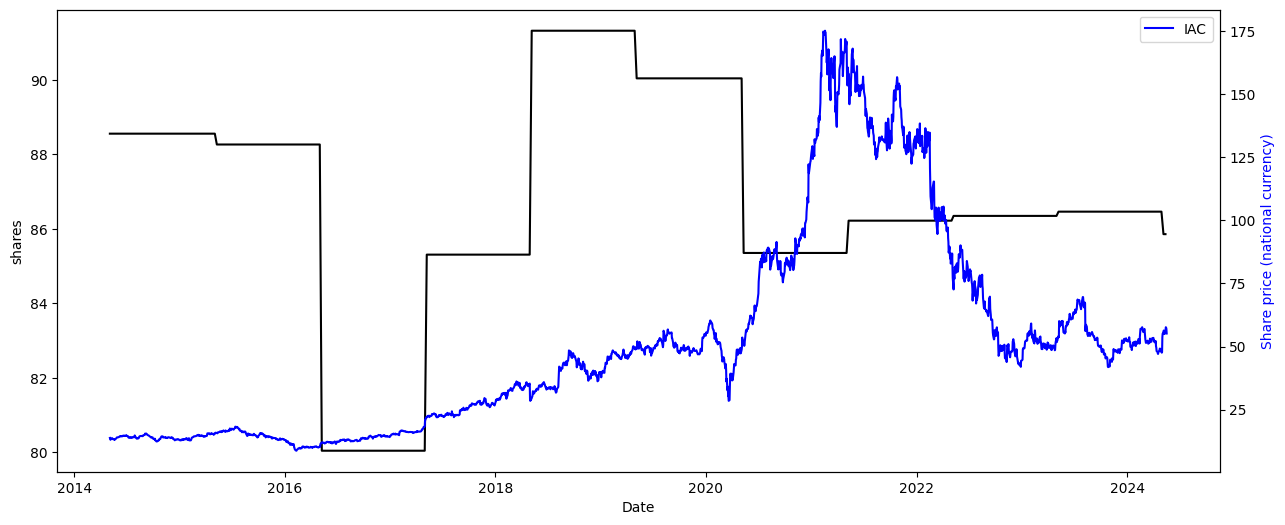

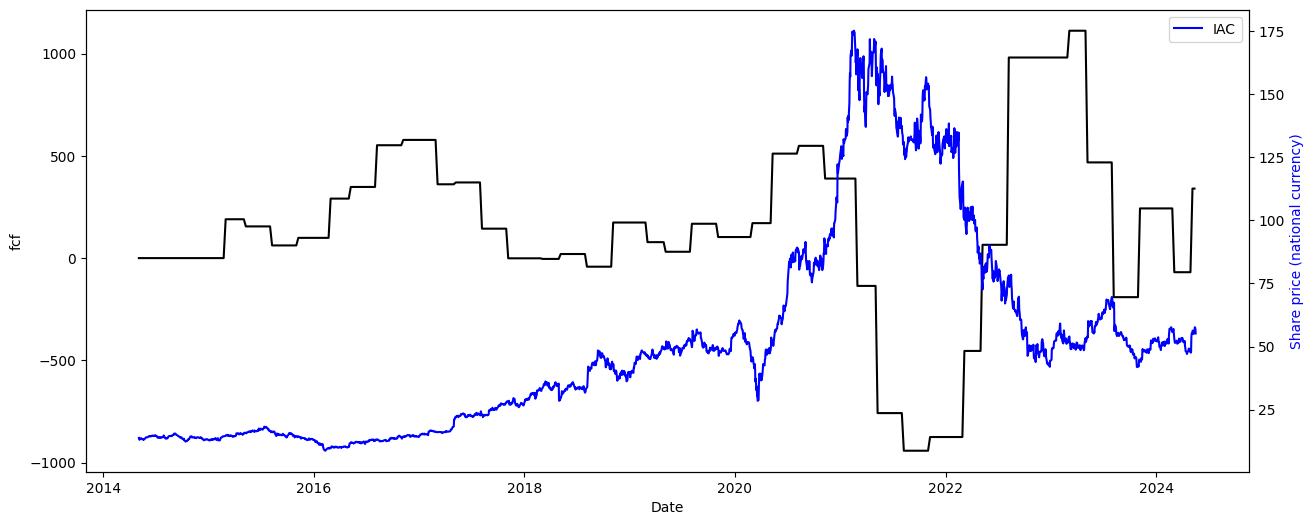

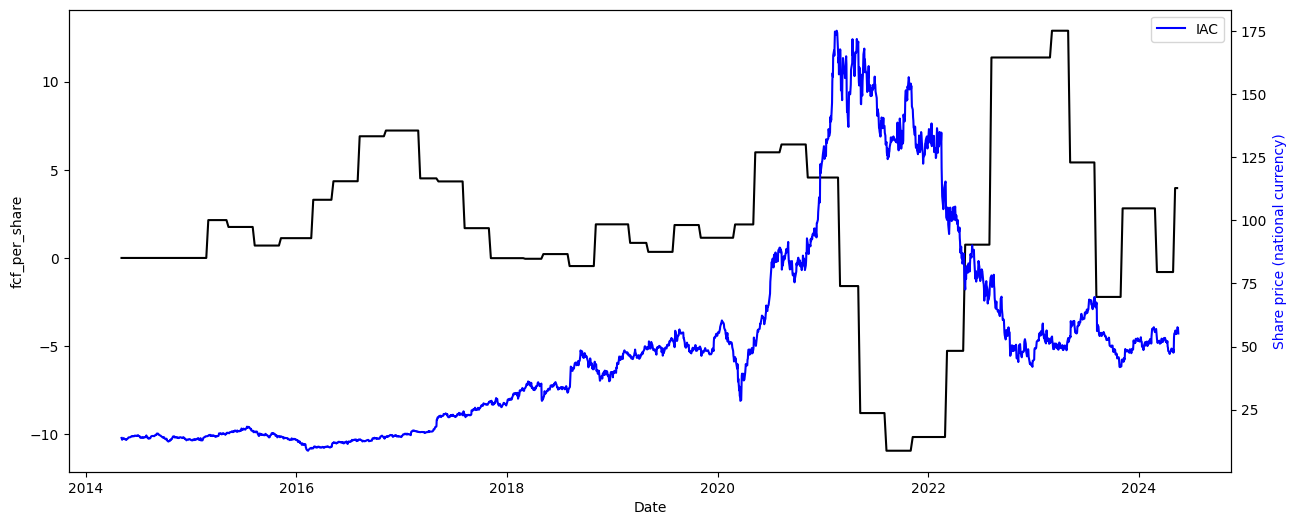

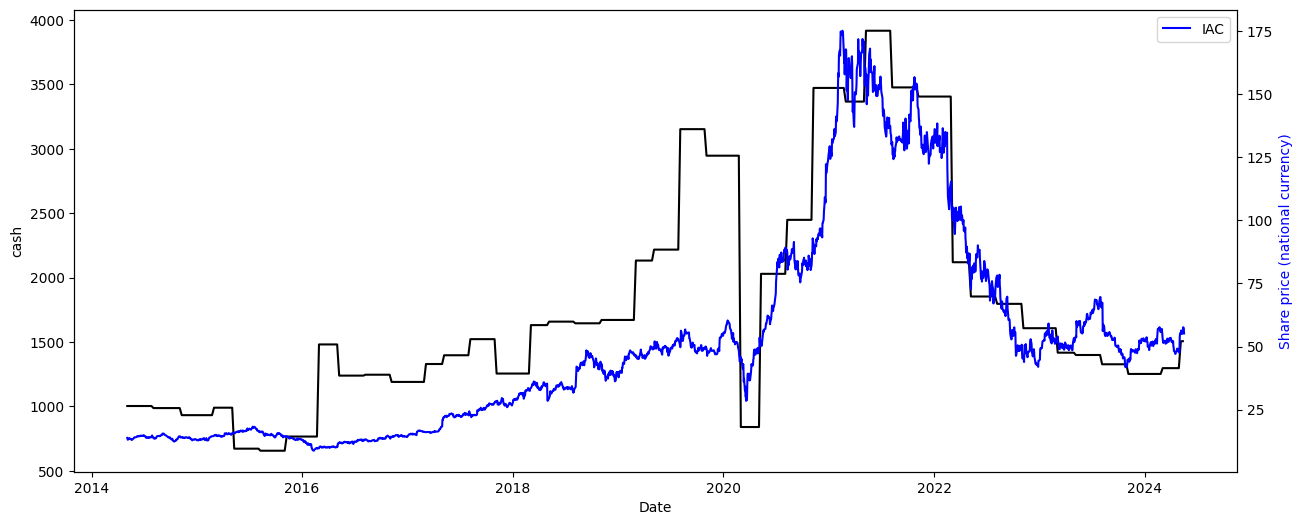

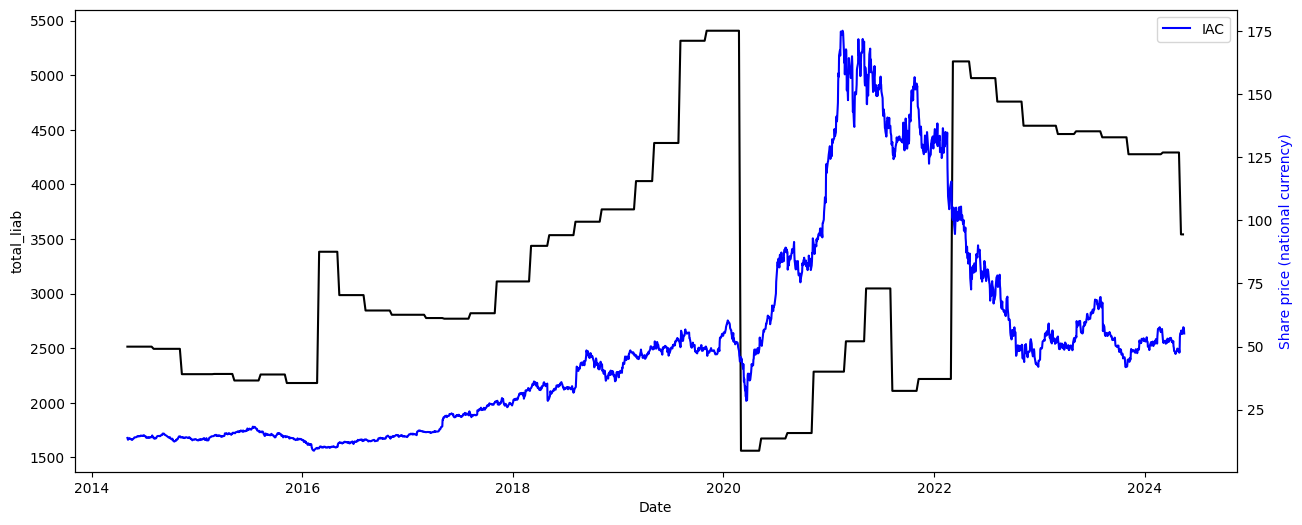

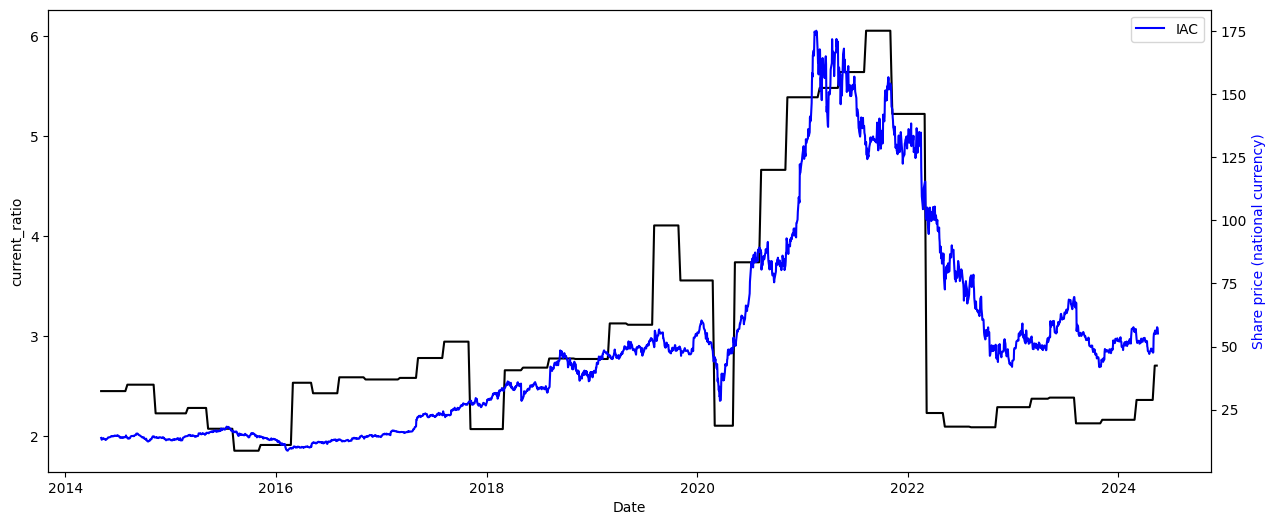

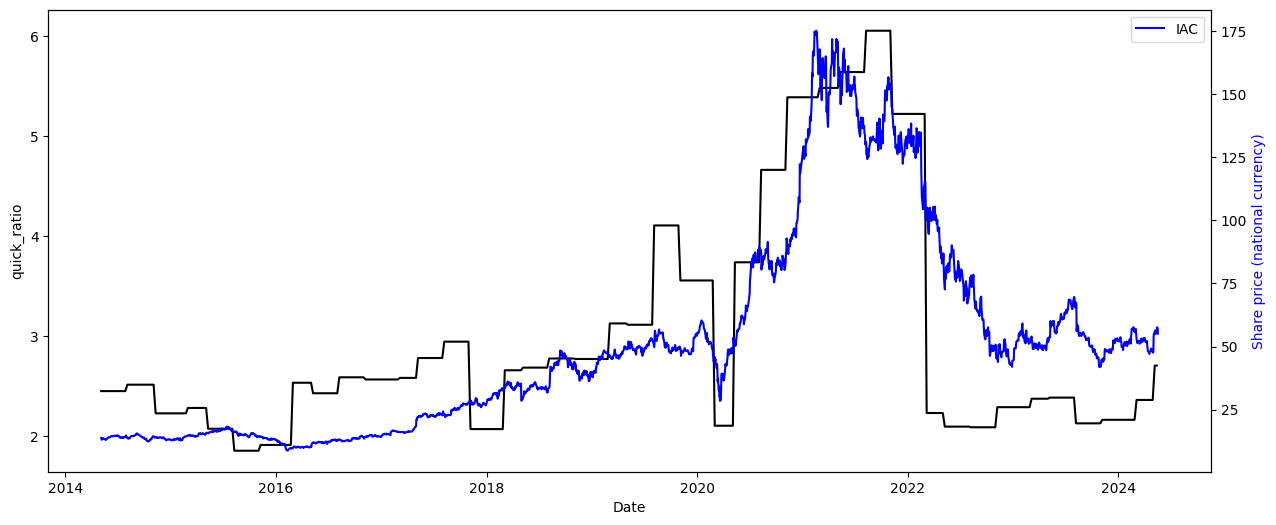

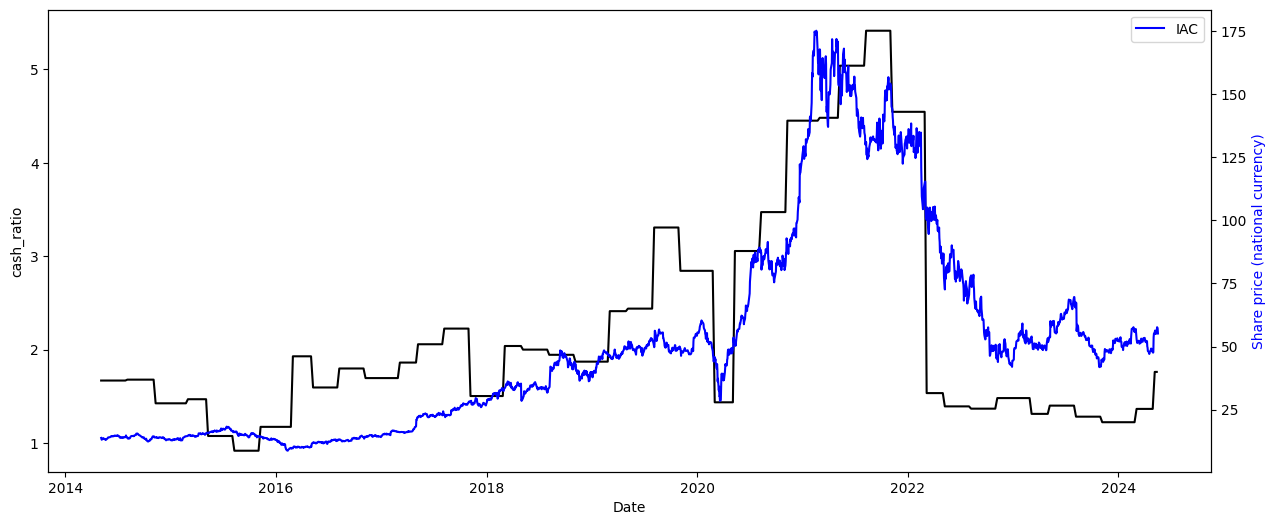

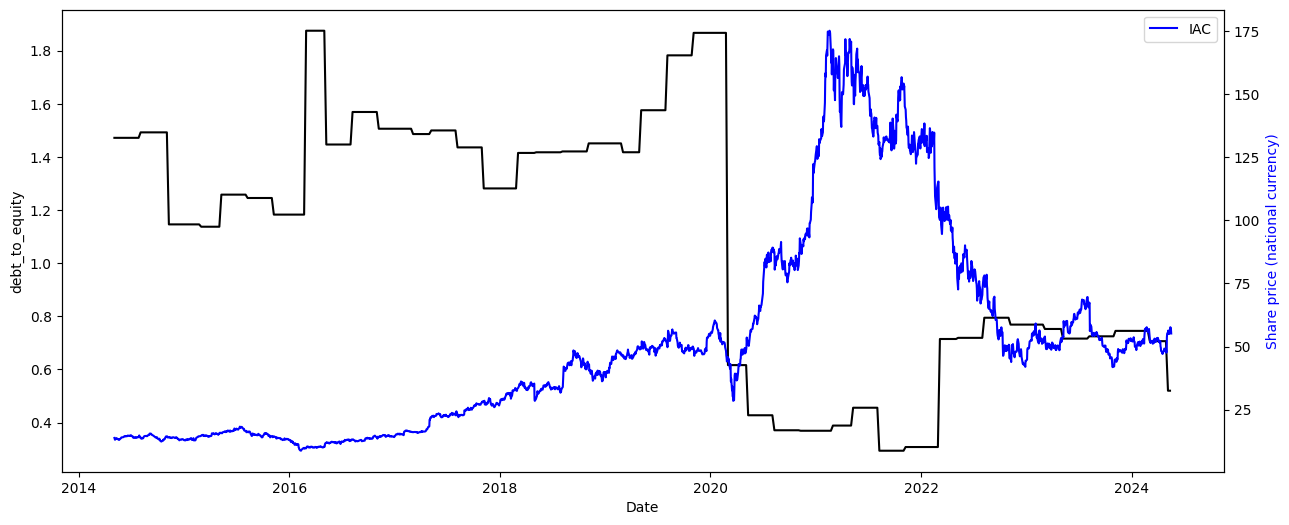

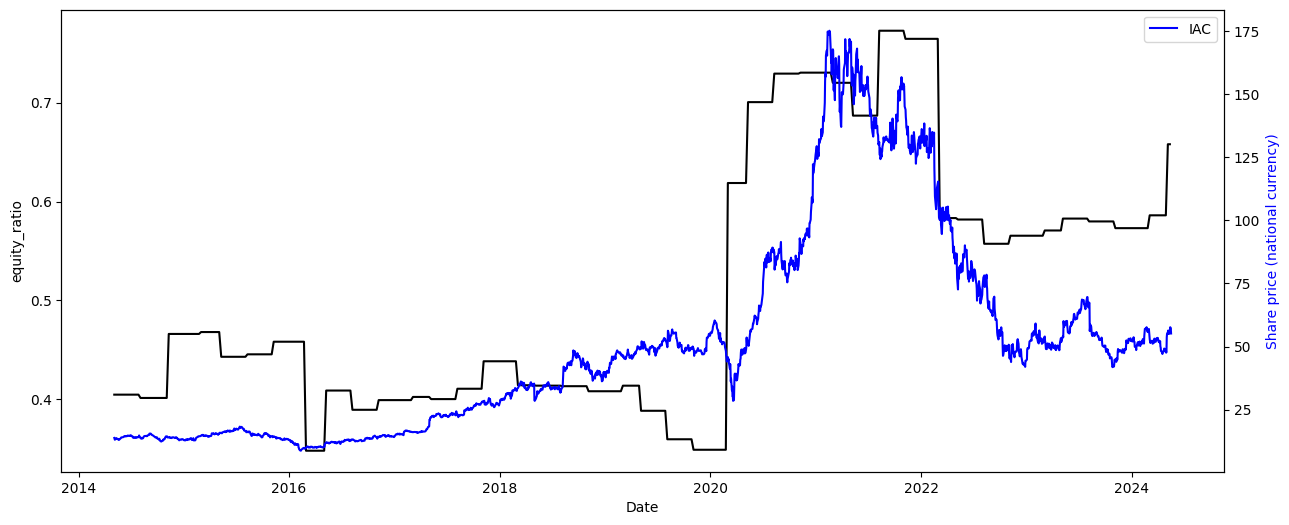

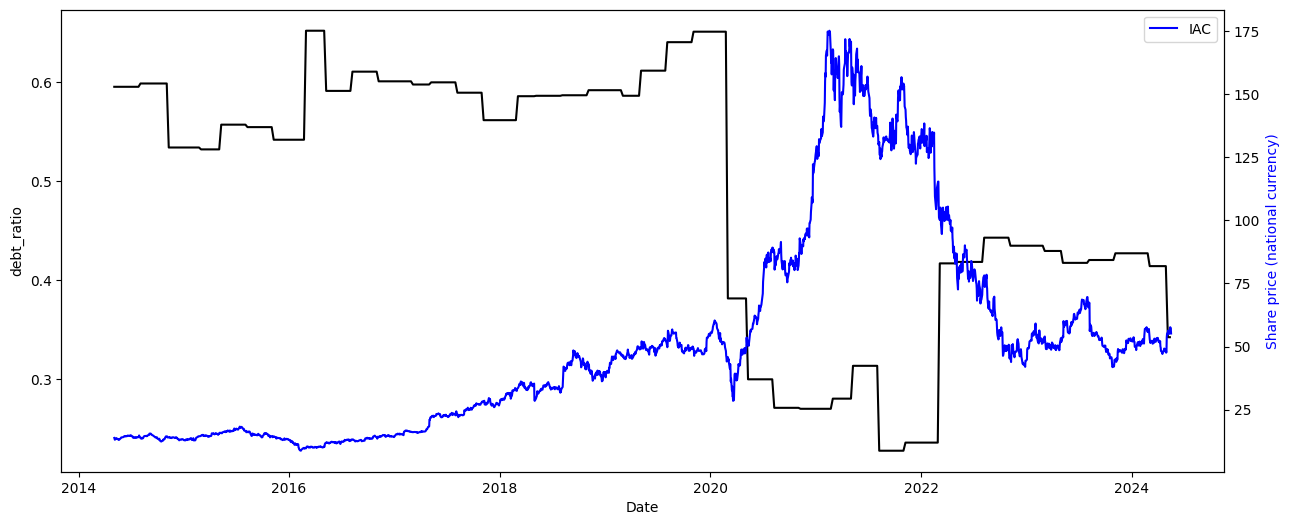

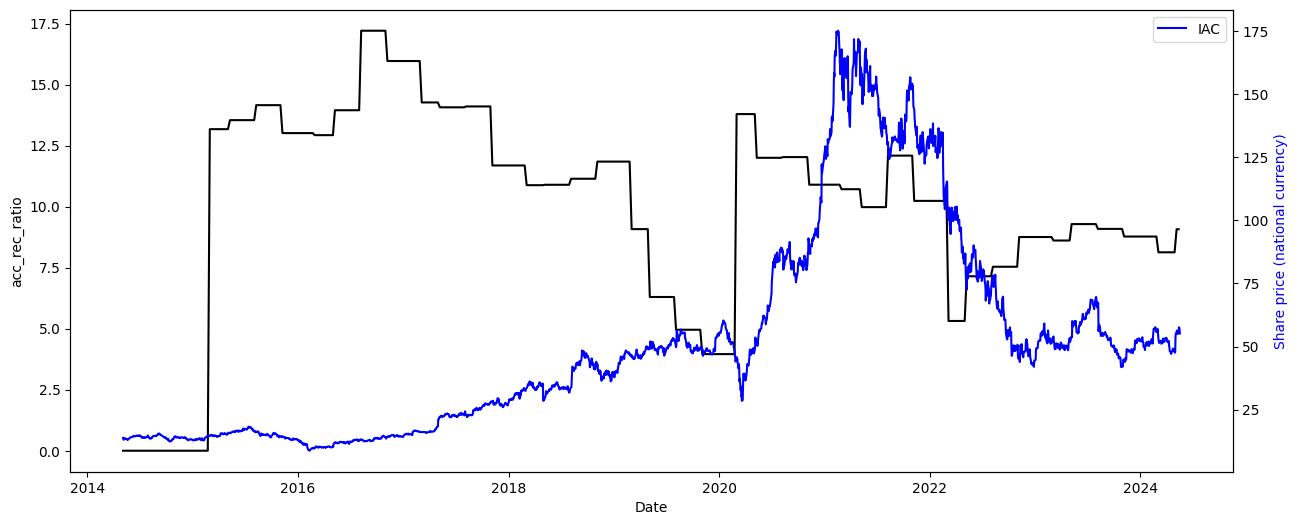

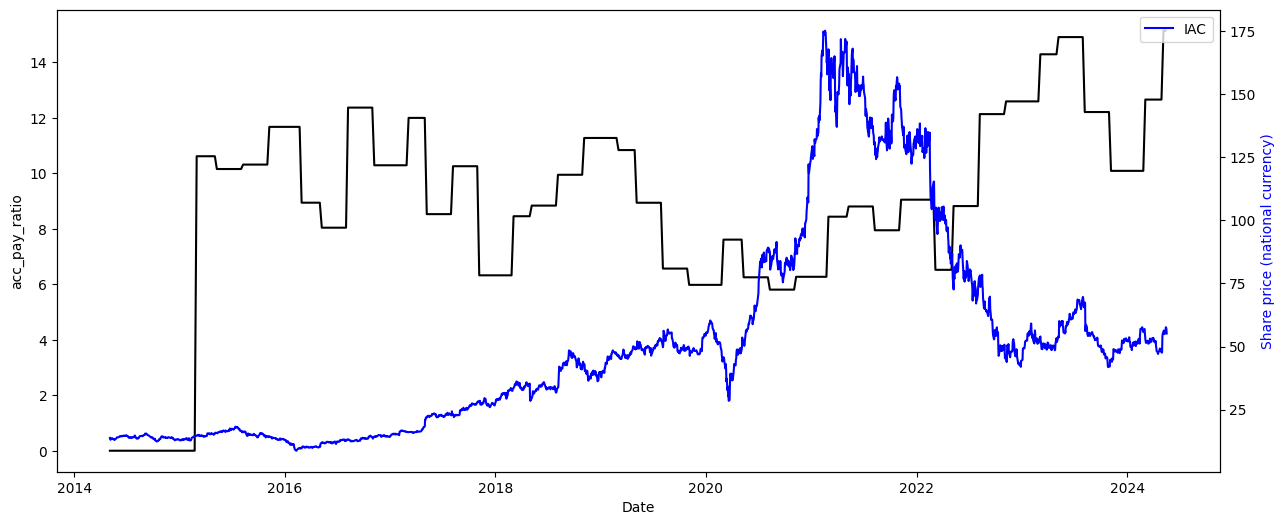

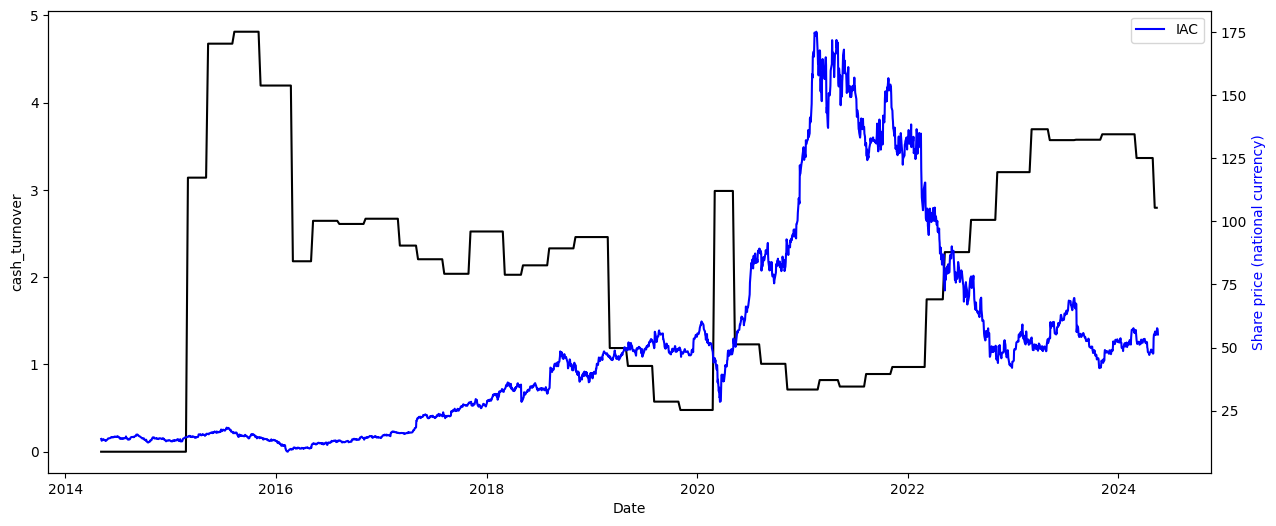

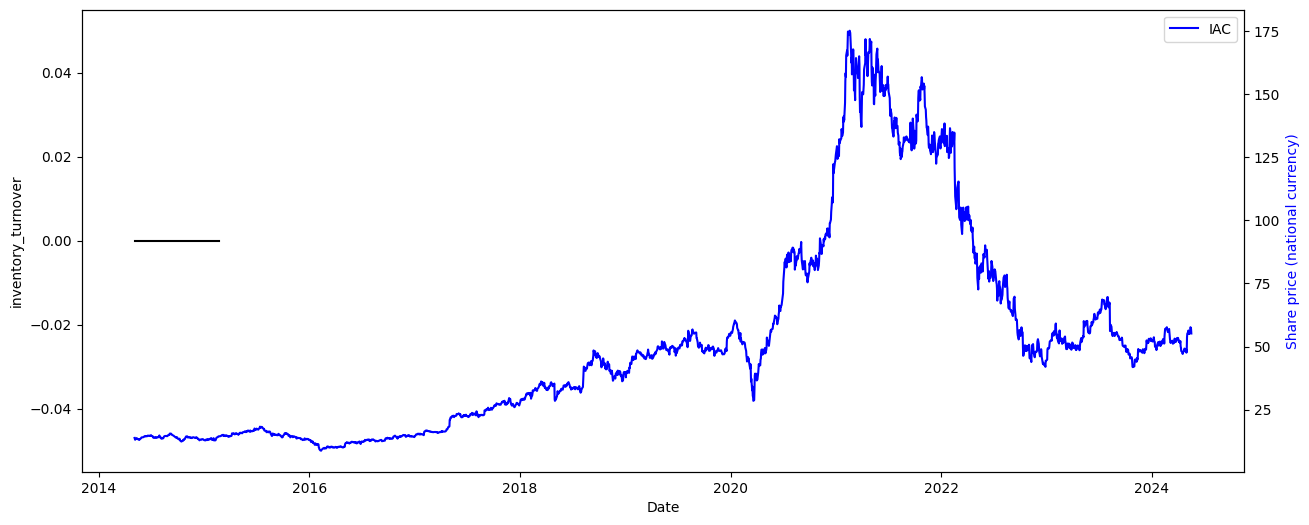

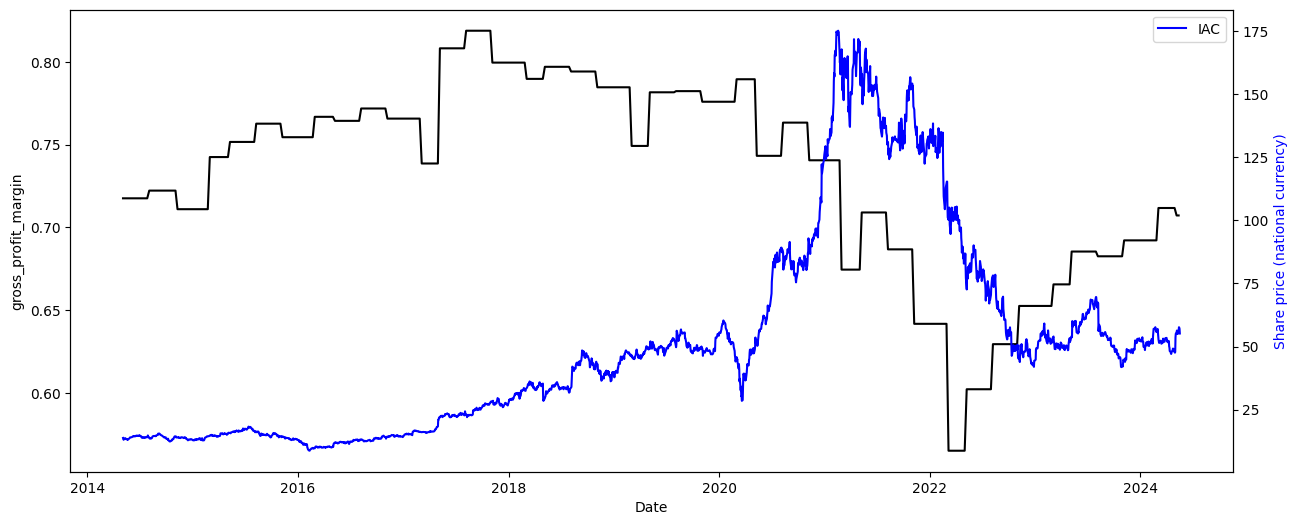

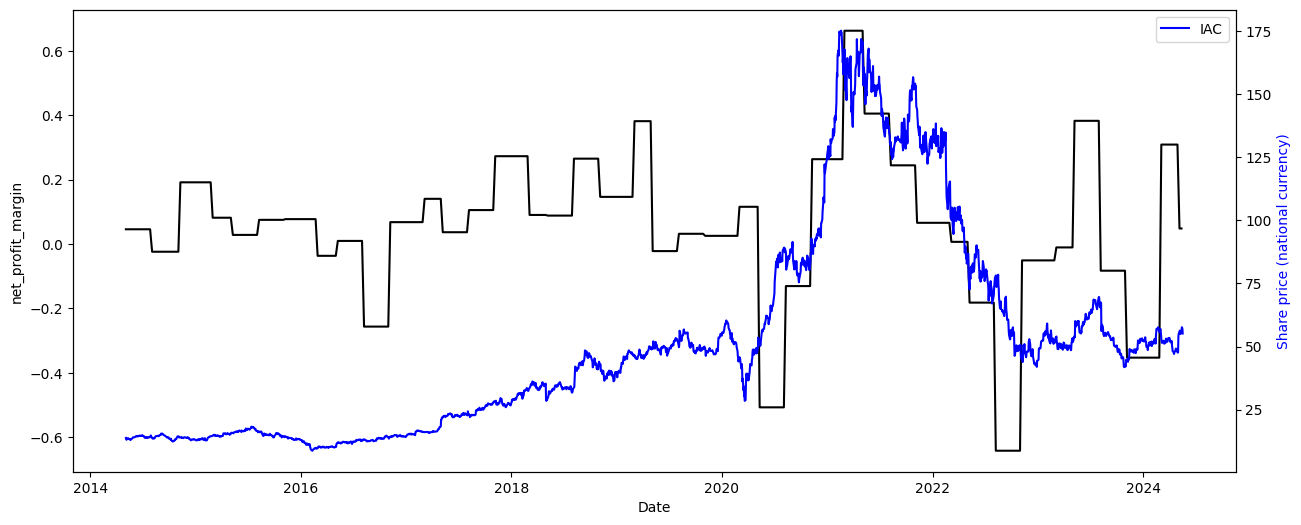

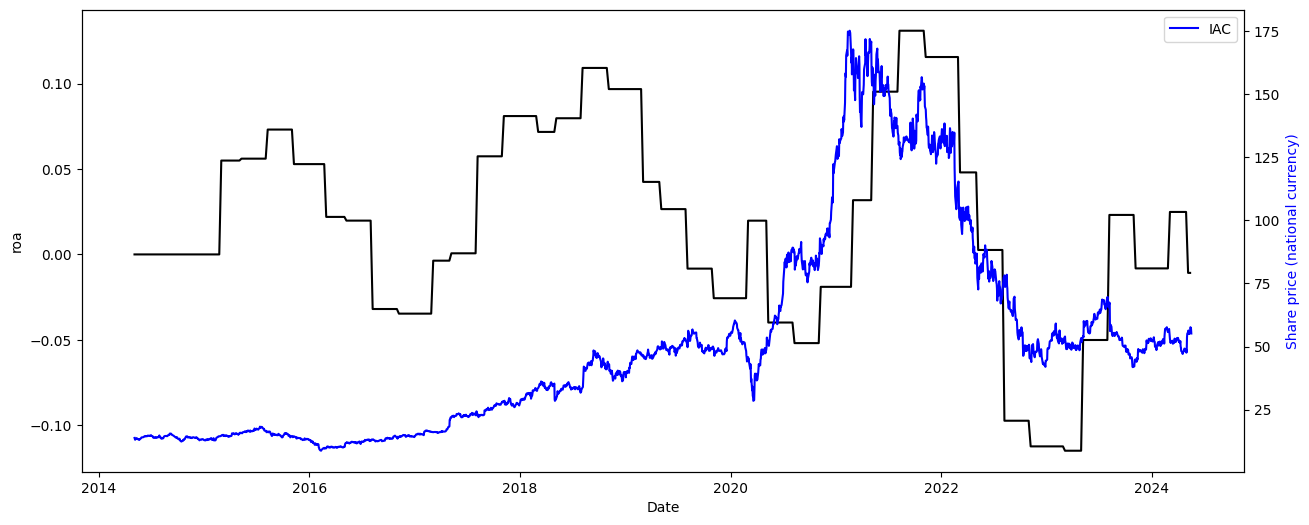

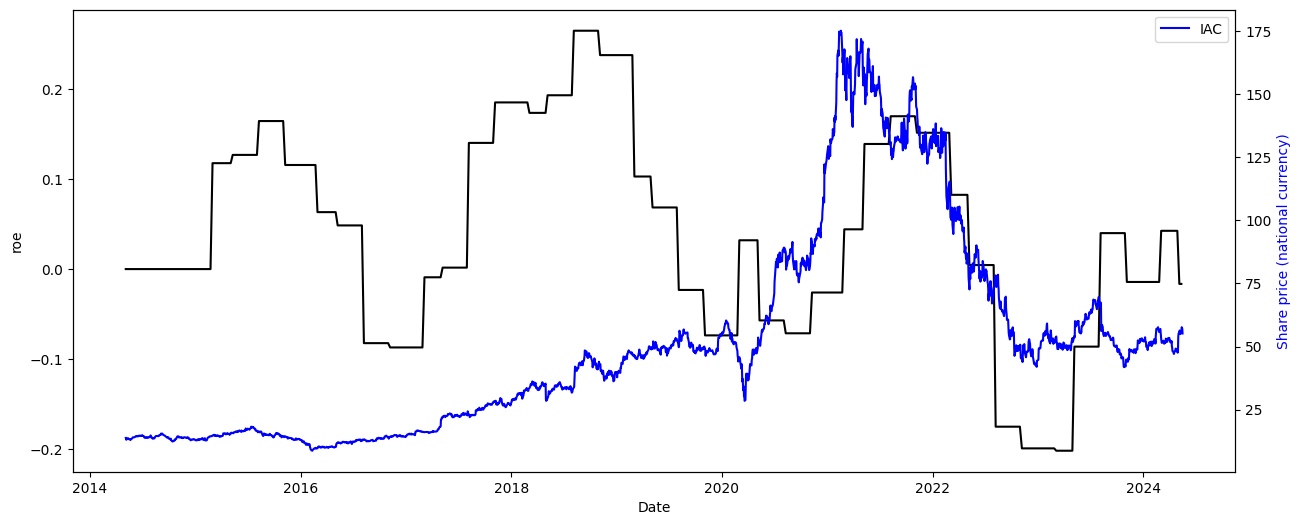

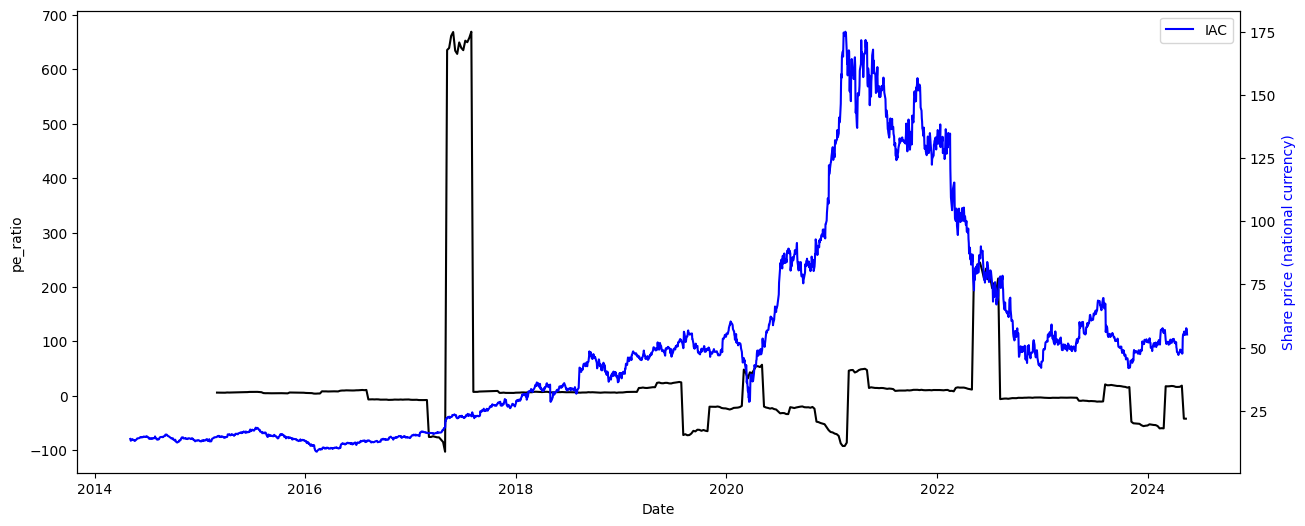

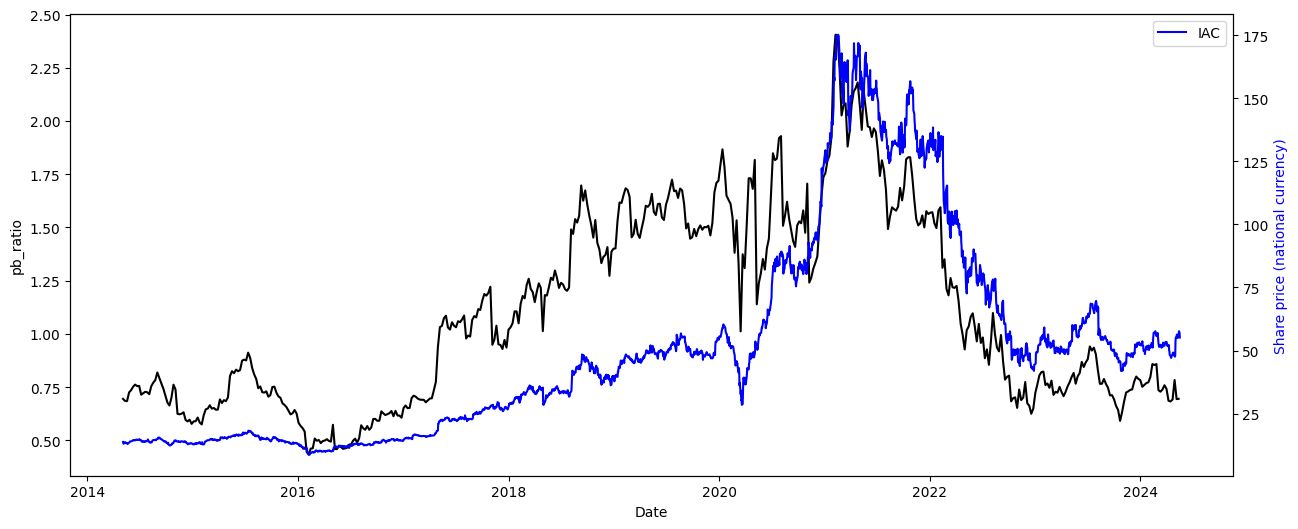

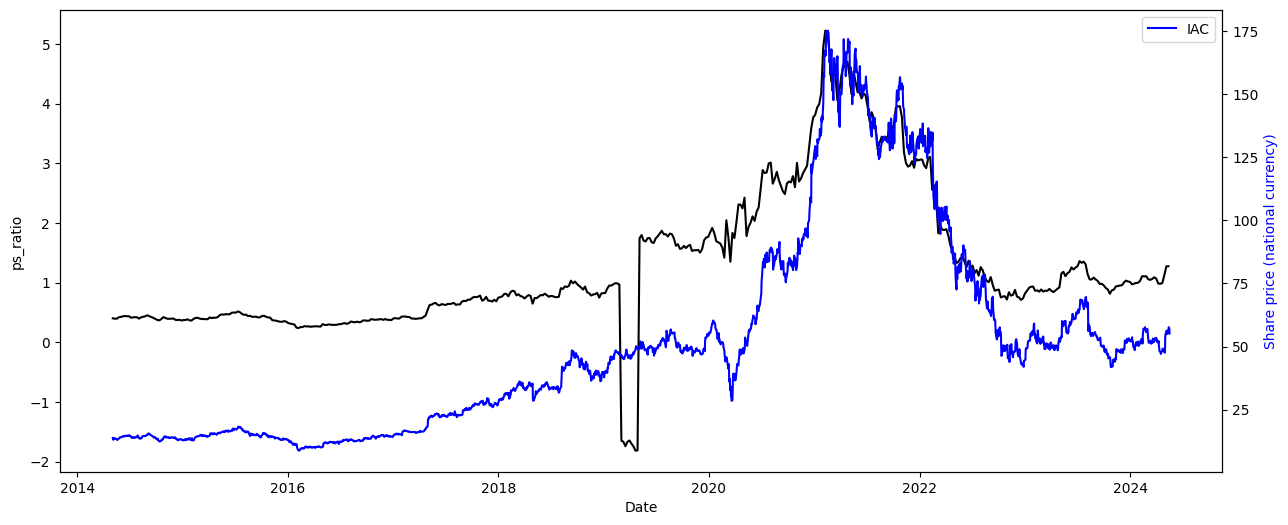

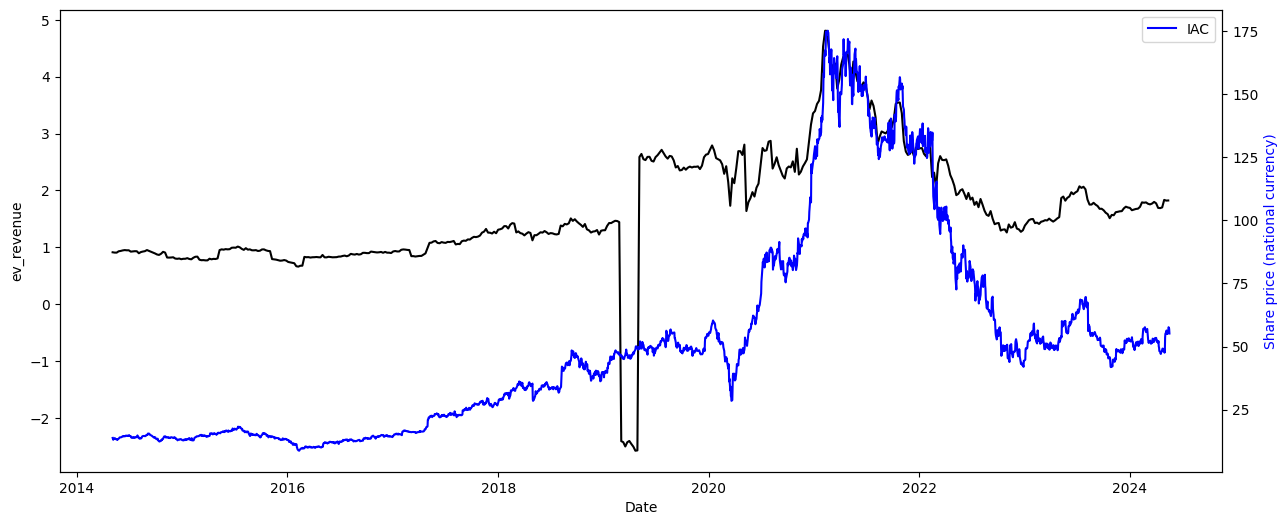

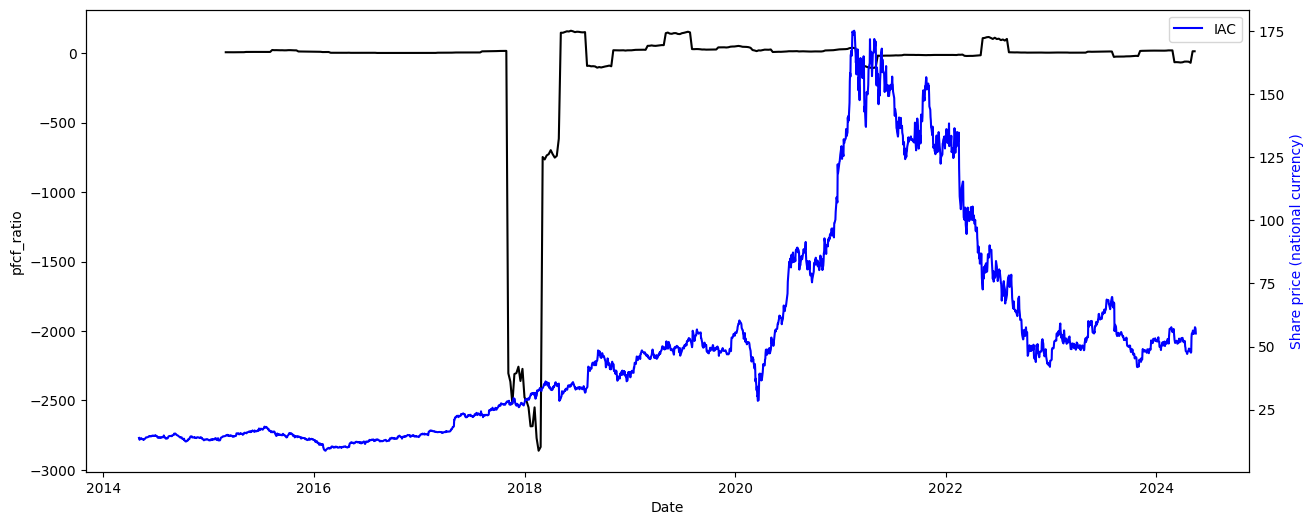

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

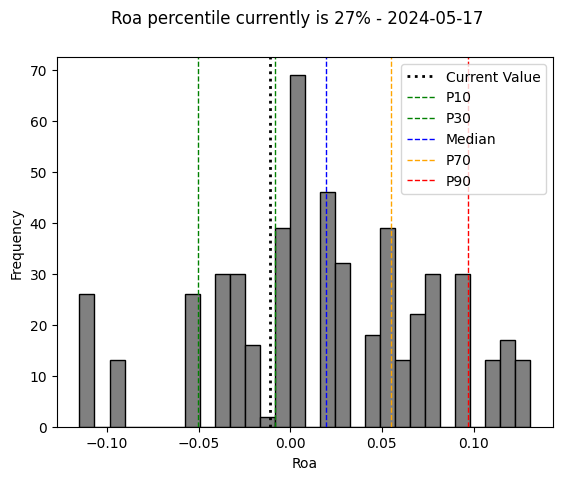

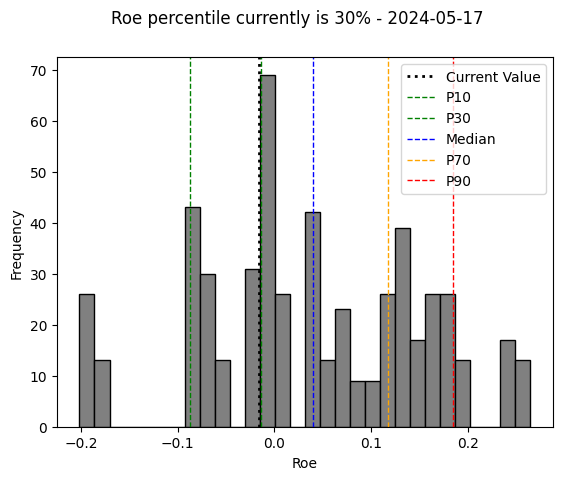

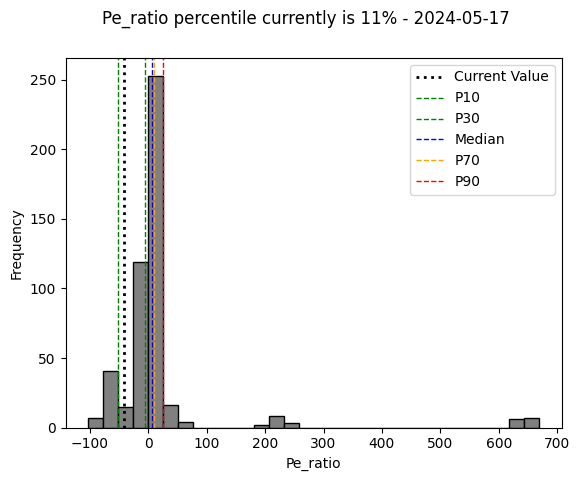

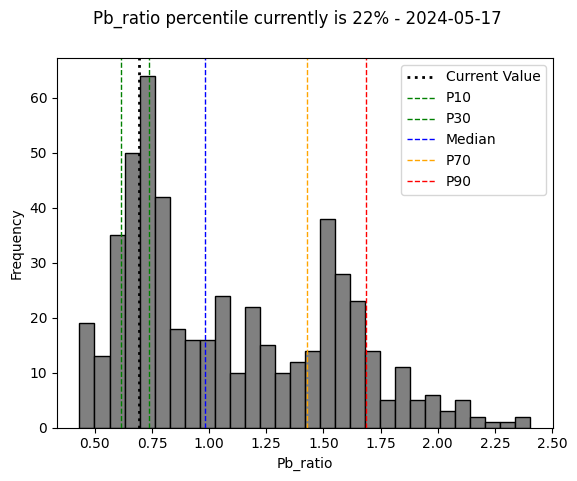

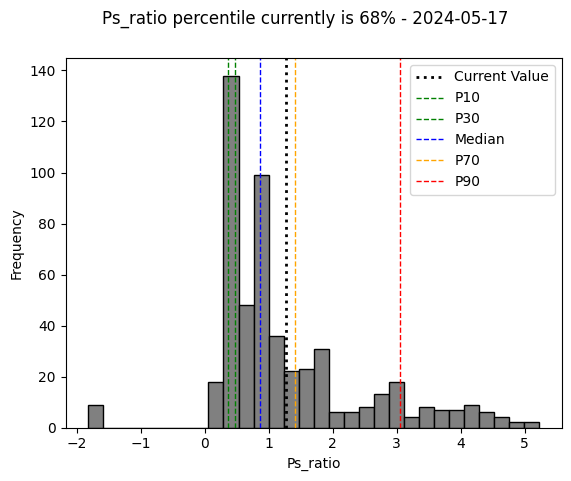

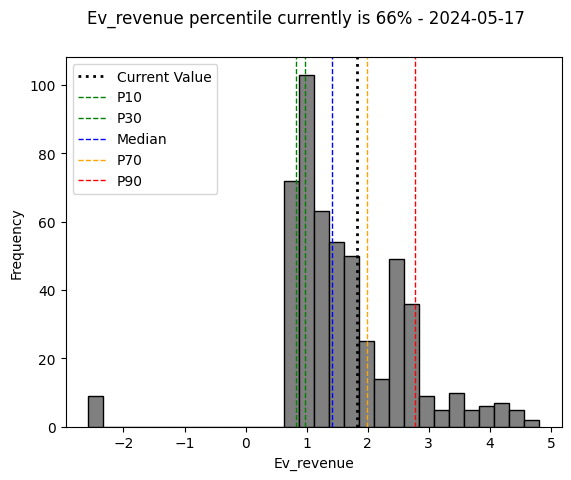

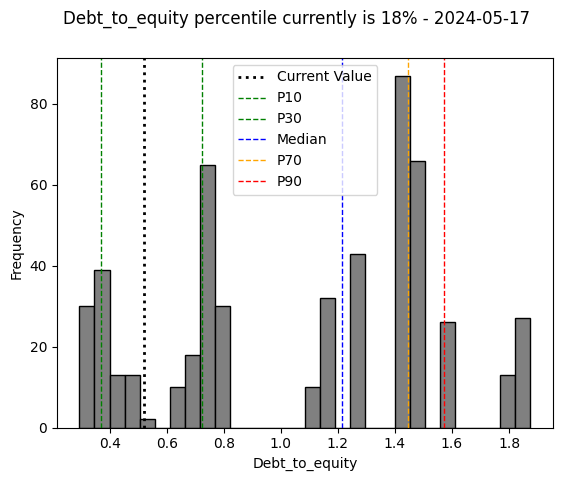

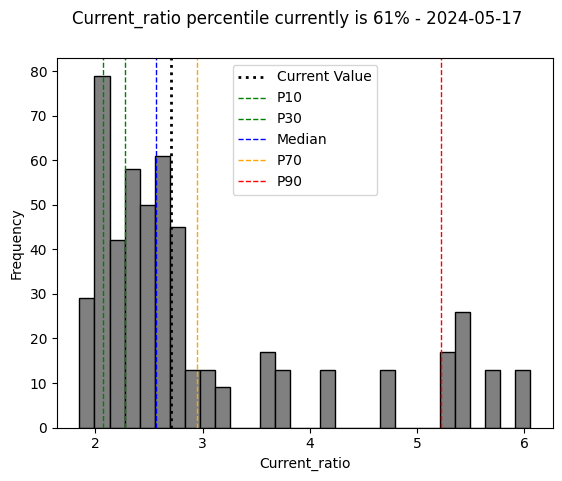

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.969655,0.030806,0.308914,0.134356,0.055645,0.040947,0.236293
roe,0.969655,1.000000,0.021868,0.265412,0.017113,-0.049318,0.127403,0.102278
pe_ratio,0.030806,0.021868,1.000000,-0.041360,-0.105785,-0.101467,0.094703,-0.105996
pb_ratio,0.308914,0.265412,-0.041360,1.000000,0.746003,0.657669,-0.293826,0.756893
ps_ratio,0.134356,0.017113,-0.105785,0.746003,1.000000,0.949077,-0.662399,0.833475
ev_revenue,0.055645,-0.049318,-0.101467,0.657669,0.949077,1.000000,-0.541725,0.676374
debt_to_equity,0.040947,0.127403,0.094703,-0.293826,-0.662399,-0.541725,1.000000,-0.460873
current_ratio,0.236293,0.102278,-0.105996,0.756893,0.833475,0.676374,-0.460873,1.000000


0 timestemos have been found!


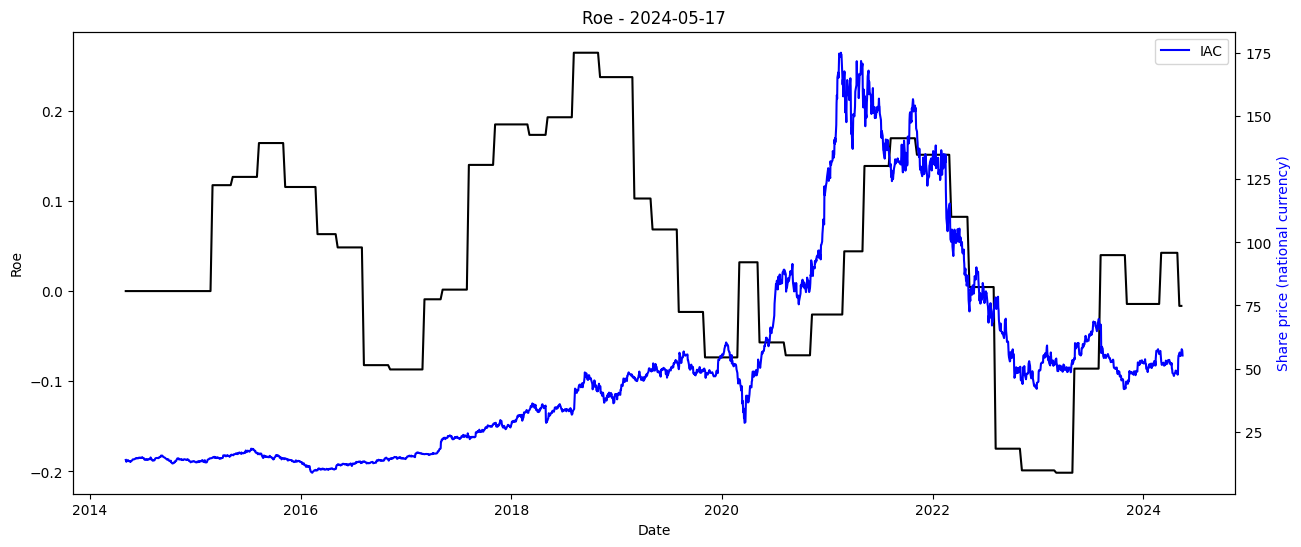

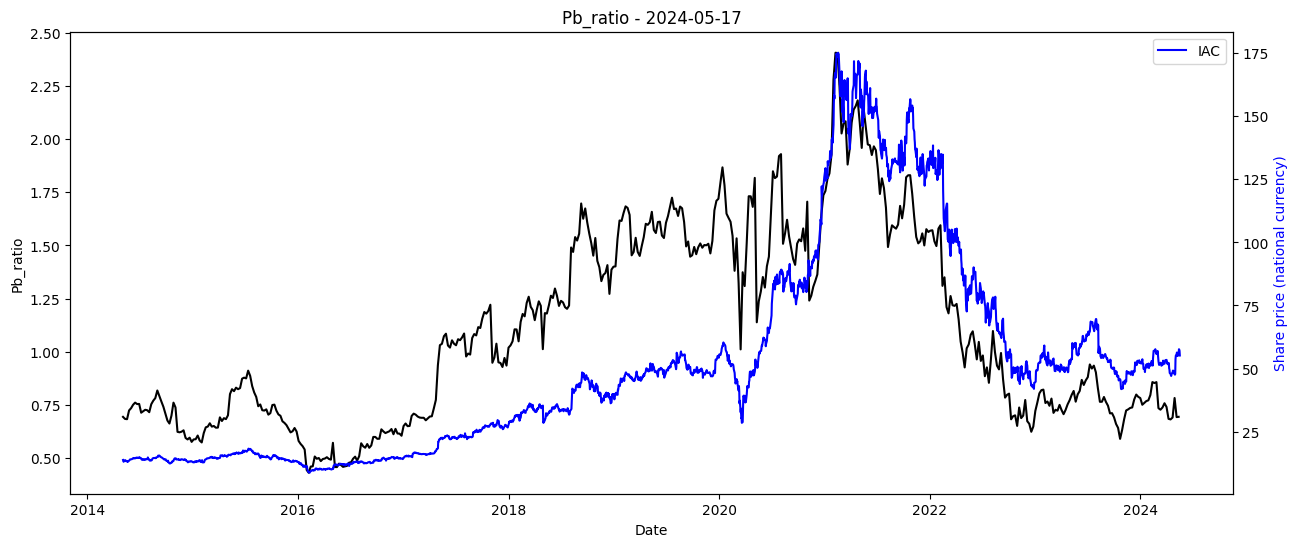

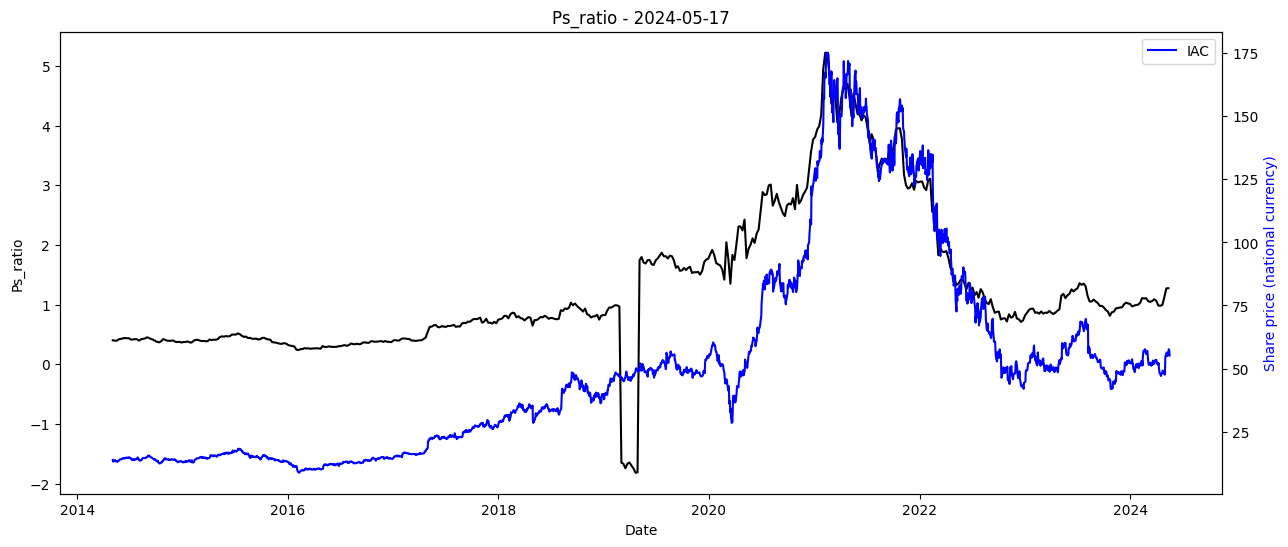

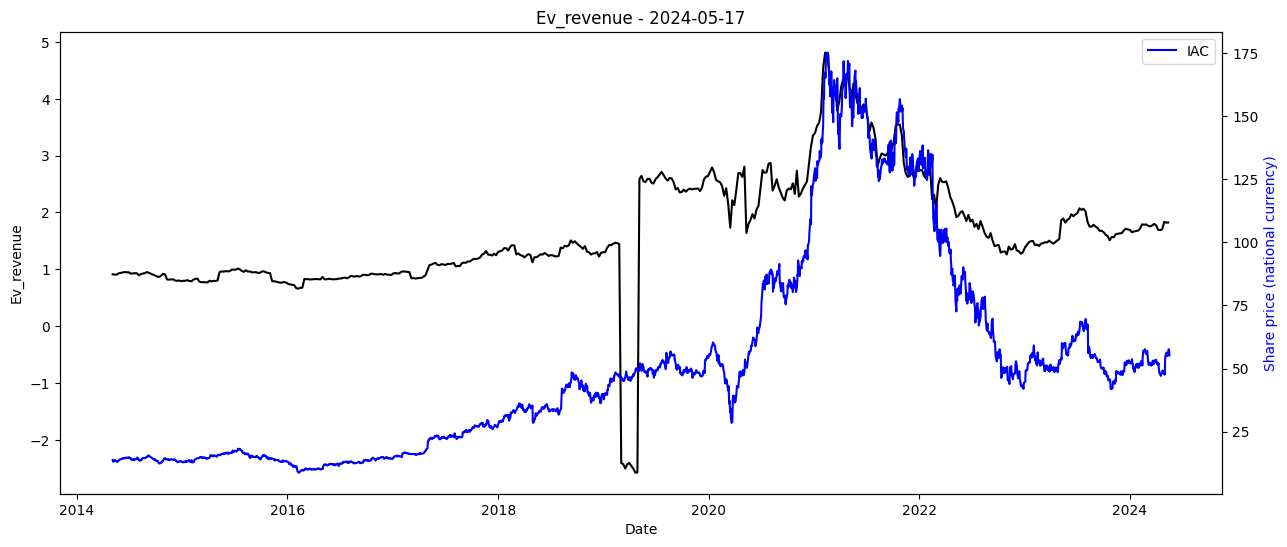

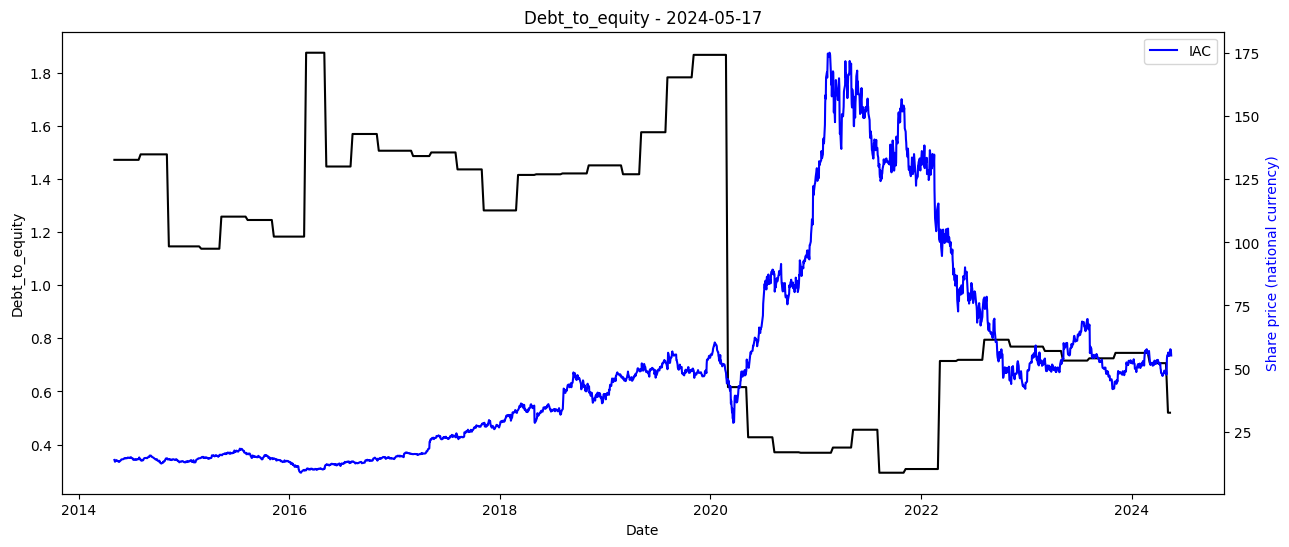

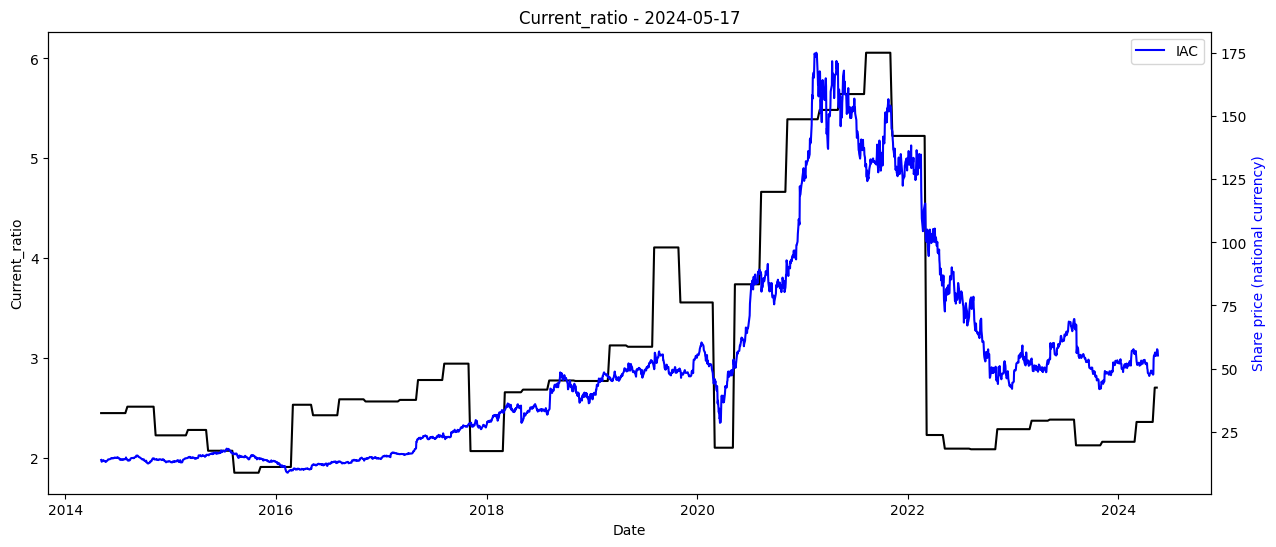

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )